In [6]:
import tensorflow as tf
import numpy as np
import rocket_tools as rt
from keras import backend 
from keras.backend import learning_phase
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
def train_model(writer_path, sess,train_op,loss, model_path, steps=30000, batch_size=32, image_size=128, n_images=3):
    print 'Start'
#    x_input = tf.placeholder(tf.float32,
#                             [None, image_size, image_size, n_images],
#                             name='input')
#    y_true = tf.placeholder(tf.float32,
#                            [None, image_size, image_size, n_images],
#                            name='mask_true')
#    y_pred = output(x_input)
#
#    loss_op = -rt.losses.dice_coef(y_true, y_pred)
#    adam = tf.train.AdamOptimizer()
#    train_op = adam.minimize(loss_op)

    
    image_generator = rt.image_gen.ImageGenerator(image_size=(image_size, image_size), snr_mean=6, snr_std=3)
    batch_generator = rt.batch_generator.BatchGenerator(image_generator, batch_size,
                                                        n_images=n_images)
#    with tf.variable_scope('metrics'):
    #    # tf.summary.scalar('dice', rt.losses.dice_coef(y_true, y_pred))
#        tf.summary.scalar('cross_entropy', rt.losses.binary_crossentropy(y_true, y_pred))
#        tf.summary.scalar('jacard', rt.losses.jacard_coef(y_true, y_pred))
#        tf.summary.scalar('accuracy', rt.metrics.accuracy(y_true, y_pred))
#        tf.summary.scalar('IoU', rt.metrics.IoU(y_true, y_pred))
#        tf.summary.scalar('log_loss', loss_op)
#        tf.summary.image('input', x_input[:1, :, :, :1])
#        tf.summary.image('pred', y_pred[:1, :, :, :1])
#        tf.summary.image('mask', y_true[:1, :, :, :1])
#        summary_op = tf.summary.merge_all()
#        writer = tf.summary.FileWriter(writer_path)


    # initialize training session
    #sess = tf.InteractiveSession()
    #sess.run(tf.global_variables_initializer())

    print('started training')
    for step in range(steps):
        x_batch, y_label = next(batch_generator)
        #_, summary =
        sess.run(train_op, feed_dict={ x: x_batch, label: y_label})
        #writer.add_summary(summary, step)
        if step % 10 == 0:
            x_batch, y_label = next(batch_generator)
            print(str(step) + ' ' + str(sess.run(loss, feed_dict={x: x_batch,
                                                               label: y_label})))
        if step % 5000 == 0:
            saver = tf.train.Saver()
            Model_path = './../saved_models_n/snr_all_with_rt_steps={}'.format(step)
            saver.save(sess, Model_path)

    print('finished training')
    saver = tf.train.Saver()
    saver.save(sess, model_path)


    #train_model(model, writer_path=TB_PATH, model_path=MODEL_PATH, sess=sess)


In [8]:
if __name__ == "__main__":
    # parsing
    # from argparse import ArgumentParser
    # parser = ArgumentParser()

    # parser.add_argument('--snr', type=float, required=True)
    # options = parser.parse_args()

    tf.reset_default_graph()

    image_size = 128
    n_images = 3
    out_channel = 3

    TB_PATH = './../tensorboard/u_net/image_size={}_snr_all_tf'.format(image_size)
    MODEL_PATH = './../saved_models/u_net_image_size={}_snr_all_tf'.format(image_size)
    os.system('rm -rf {}'.format(TB_PATH))
    x = tf.placeholder("float", [None, image_size, image_size, 3],
                       name="input")
    output = rt.model_tf.Unet(x,out_channel, training=True)
    label = tf.placeholder("float", [None, image_size, image_size, out_channel])
    loss = tf.reduce_mean(tf.square(label - output))
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)

    train_model(writer_path=TB_PATH, model_path=MODEL_PATH, sess=sess, train_op=train_step, loss=loss)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Start
started training


ResourceExhaustedError: OOM when allocating tensor with shape[32,128,16,16]
	 [[Node: layer6/conv_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concat_6, layer6/conv_1/kernel/read)]]

Caused by op u'layer6/conv_1/convolution', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-917005d50272>", line 20, in <module>
    output = rt.model_tf.Unet(x,out_channel, training=True)
  File "rocket_tools/model_tf.py", line 110, in Unet
    conv6 = conv_conv_pool(up6, [64, 64], training, flags, name=6, pool=False)
  File "rocket_tools/model_tf.py", line 43, in conv_conv_pool
    name="conv_{}".format(i + 1))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/convolutional.py", line 551, in conv2d
    return layer.apply(inputs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/base.py", line 503, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/layers/convolutional.py", line 158, in call
    data_format=utils.convert_data_format(self.data_format, self.rank + 2))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 672, in convolution
    op=op)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 664, in op
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,128,16,16]
	 [[Node: layer6/conv_1/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concat_6, layer6/conv_1/kernel/read)]]


In [12]:
x_input = tf.placeholder(tf.float32, [None, 128, 128, 3], 
                             name='input')
y_pred = rt.model_tf.Unet(x_input, training=False)
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, './../saved_models_n/snr_all_with_rt_steps=5000')

TypeError: Unet() takes at least 2 arguments (2 given)

In [ ]:
#x_input = tf.placeholder(tf.float32, [None, 128, 128, 3], 
                             name='input')
#y_pred = model(x_input)
#pred = y_pred.eval(feed_dict={x_input:-0.5*np.ones([1,128,128,3], dtype='float32'), learning_phase():1})

In [10]:
image_generator = rt.image_gen.ImageGenerator(image_size=(128, 128), snr_mean=2, snr_std=0)
batch_generator = rt.batch_generator.BatchGenerator(image_generator, batch_size=5, n_images=3)

x_batch, y_batch =next(batch_generator)
pred_s = sess.run(y_pred, feed_dict={x_input: x_batch, learning_phase(): 1})

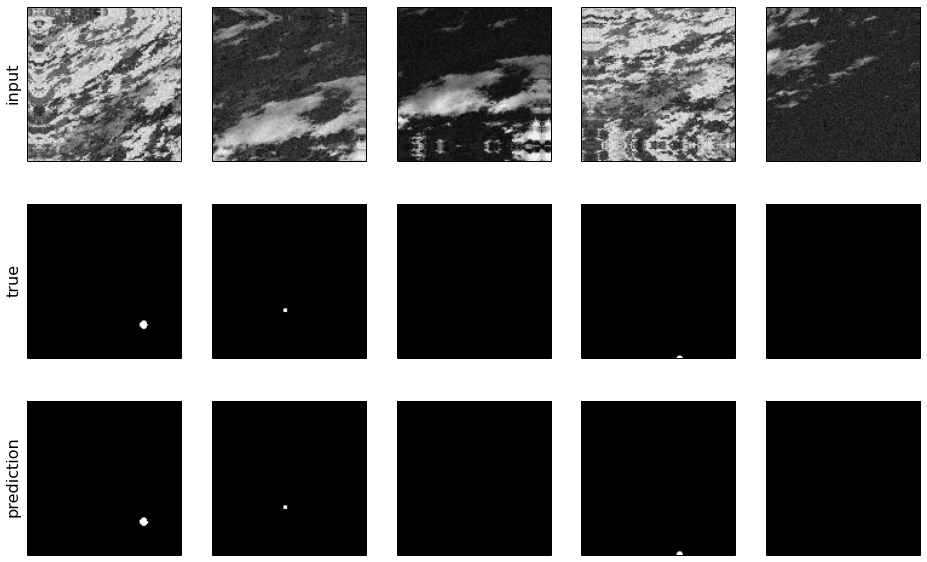

In [11]:
f, axes = plt.subplots(3, 5, figsize=(16,10))
axes[0, 0].set_ylabel('input', fontsize=16)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(x_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[1, 0].set_ylabel('true', fontsize=16)
for i in range(5): 
    ax = axes[1, i]
    ax.imshow(y_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[2, 0].set_ylabel('prediction', fontsize=16)
for i in range(5):
    ax = axes[2, i]
    ax.imshow(pred_s[i][:, :, 0], vmin=0.0, vmax=1.0, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

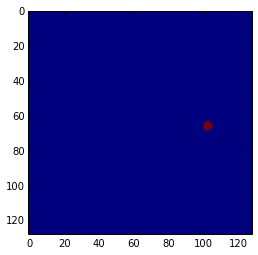

In [23]:
plt.imshow(pred_s[1][:, :, 0])